# **Predicting house prices: A regression model**

**The Boston housing price dataset**

In [ ]:
# Loading the Boston housing dataset
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import boston_housing
import numpy as np

In [ ]:
(train_data, train_targets), (test_data, test_targets) = (boston_housing.load_data())

57026/57026 [==============================] - 0s 0us/step


In [ ]:
# 404 training sample with 13 numerical features
train_data.shape

(404, 13)

In [ ]:
# 102 test sample with 13 numerical features
test_data.shape

(102, 13)

In [ ]:
train_targets[0:10]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

**Preparing the data**

A widespread best practice for dealing with such data is to do feature-wise normalization:

For each feature in the input data (a column in the input data matrix), we subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit standard deviation.

In [ ]:
# Normalizing the data
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

**Building the model**

In [ ]:
# Model definition

def build_model():
  model = keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(1)
  ])
  model.compile(
      optimizer="rmsprop",
      loss="mse",
      metrics=["mae"]
  )
  return model

**Validating approach using K-fold validation**

 **K-fold validation** consists of splitting the available data into K partitions (typically K = 4 or 5), instantiating K identical models, and training each one on K – 1 partitions while evaluating on the remaining partition.

The validation score for the model used is then the average
of the K validation scores obtained.

In [ ]:
# K-fold validation

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
  print(f"Processing fold #{i}")

  # Prepares the validation data: data from partition #k
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

  # Prepares the training data: data from allother partitions
  partial_train_data = np.concatenate(
      [train_data[:i * num_val_samples],
       train_data[(i + 1) * num_val_samples:]],
      axis=0)
  partial_train_targets = np.concatenate(
      [train_targets[:i * num_val_samples],
       train_targets[(i + 1) * num_val_samples:]],
      axis=0)

  # Builds the Keras model (already compiled)
  model = build_model()

  # Trains the model (in silent mode, verbose=0)
  history = model.fit(partial_train_data, partial_train_targets,
            epochs=num_epochs, batch_size=16, verbose=0)

  # Evaluates the model on the validation data
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [ ]:
all_scores

[2.0800509452819824, 2.4334263801574707, 2.530818223953247, 2.3616487979888916]

In [ ]:
np.mean(all_scores)

2.351486086845398

In [ ]:
# Modify the training loop to save the per-epoch validation score log for each fold
num_epochs = 500
all_mae_histories = []
for i in range(k):
  print(f"Processing fold #{i}")

  # Prepares the validation data: data from partition #k
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

  # Prepares the training data: data from allother partitions
  partial_train_data = np.concatenate(
      [train_data[:i * num_val_samples],
       train_data[(i + 1) * num_val_samples:]],
      axis=0)
  partial_train_targets = np.concatenate(
      [train_targets[:i * num_val_samples],
       train_targets[(i + 1) * num_val_samples:]],
      axis=0)

  # Builds the Keras model (already compiled)
  model = build_model()

  # Trains the model (in silent mode, verbose=0)
  history = model.fit(partial_train_data, partial_train_targets,
                      validation_data=(val_data, val_targets),
                      epochs=num_epochs, batch_size=16, verbose=0)

  mae_history = history.history["val_mae"]
  all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [ ]:
# Building the history of successive mean K-fold validation scores
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

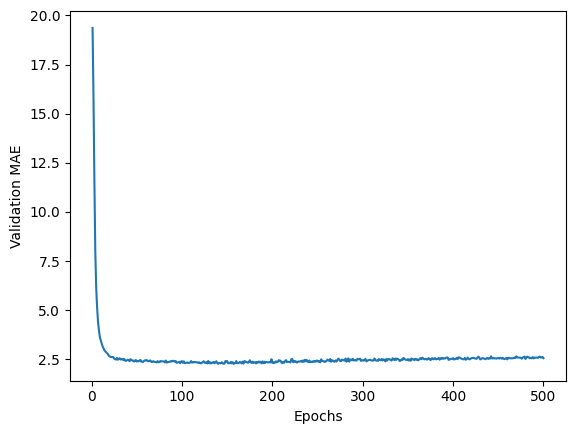

In [ ]:
# Plotting validation scores by epoch
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

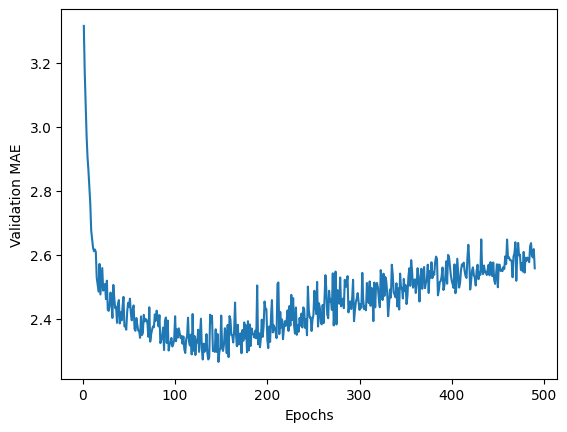

In [ ]:
# Plotting validation scores, excluding the first 10 data points

# validation MAE stops improving significantly after 120–140 epochs (this number includes the 10 epochs omitted)
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

In [ ]:
# Training the final model
model = build_model()
model.fit(train_data, train_targets,
          epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 4ms/step - loss: 425.0762 - mae: 19.2052


In [ ]:
test_mse_score

425.076171875

In [ ]:
test_mae_score

19.205163955688477

**Generating predictions on new data**

In [ ]:
predictions = model.predict(test_data)

4/4 [==============================] - 0s 3ms/step


In [ ]:
predictions[0]

array([20.054682], dtype=float32)

The first house in the test set is predicted to have a price of about $20,000